# Predicting House Prices on [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [1]:
!pip install mxnet
!pip install d2l
# If pandas is not installed, please uncomment the following line:
!pip install pandas

Traceback (most recent call last):
  File "/home/iserina/.local/bin/pip", line 7, in <module>
    from pip._internal import main
ModuleNotFoundError: No module named 'pip._internal'
Traceback (most recent call last):
  File "/home/iserina/.local/bin/pip", line 7, in <module>
    from pip._internal import main
ModuleNotFoundError: No module named 'pip._internal'
Traceback (most recent call last):
  File "/home/iserina/.local/bin/pip", line 7, in <module>
    from pip._internal import main
ModuleNotFoundError: No module named 'pip._internal'


In [2]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import pandas as pd

## Accessing and Reading Data Sets

In [3]:
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_train.csv')
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_test.csv')
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


## A Quick View of the Data

In [4]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


## Combile Train and Test for Pre-processing

In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Standardize and Replace Missing Value with 0

In [6]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features = all_features.fillna(0)

## Replace Discrete Feature with One-hot Encoding 

In [7]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

## Preprocessed Dataset

In [8]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

## Linear Regression with L2 Loss

In [9]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

## Log Root Mean Square Error 

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

A small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. 


In [10]:
def log_rmse(net, features, labels):
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

## Optimization

In [11]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## Get k-Fold Cross-Validation Data

In [12]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

##  k-Fold Cross-Validation

In [13]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## Model Selection


fold 0, train rmse: 0.136006, valid rmse: 0.159474
fold 1, train rmse: 0.130692, valid rmse: 0.153444
fold 2, train rmse: 0.132189, valid rmse: 0.158263
fold 3, train rmse: 0.140581, valid rmse: 0.143155
fold 4, train rmse: 0.123880, valid rmse: 0.162164
5-fold validation: avg train rmse: 0.132670, avg valid rmse: 0.155300


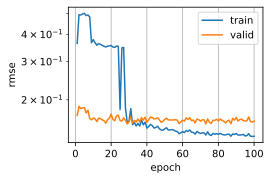

In [14]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))


##  Predict and Submit

In [15]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(range(1, num_epochs+1), train_ls, xlabel='epoch', ylabel='rmse',
            yscale='log')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)


## Tuning Ideas


1. What happens if you try to predict the log price rather than the price?
1. Is it always a good idea to replace missing values by their mean?
1. What happens if you add an indicator variable for missing values.?
1. Tune the hyperparameters through k-fold crossvalidation.
1. Change he model (layers, regularization, dropout).